# DCGAN

## dataset
- [x] mnist
- [ ] fashion mnist
- [ ] celebA

## model architecture for stable DC GANs
- [x] Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- [x] Use Batch-norm for generator and discriminator.
- [x] Remove fully connected layers.
- [x] Use Relu activation in generator for all layers except for the output, which uses Tanh.
- [x] Use leakyRelu activation in the discriminator for all layers.
  - [x] alpha = 0.2






# installation

In [1]:
# !pip install tensorflow-gpu==2.0.0-rc1
# !pip install gast==0.2.2
# !conda install -y -q seaborna


# Imports

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
print(sns.__version__)
import numpy as np
print(np.__version__)
keras = tf.keras

K = keras.backend

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2.0.0
0.9.0
1.17.2


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4425800006638236791, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11497050429068206704
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1251447329284666018
 physical_device_desc: "device: XLA_GPU device"]

# Configurations

In [3]:
batch_size = 256

epochs = 50
noise_dim = 100

# datasets

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


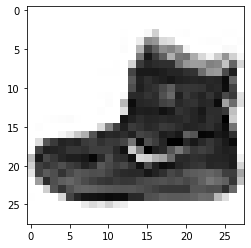

(60000, 28, 28, 1)
<PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>


In [4]:
dataset = keras.datasets.fashion_mnist.load_data()

X_train, X_test = dataset[0][0], dataset[1][0]
Y_train, Y_test = dataset[0][1], dataset[1][1]

del(dataset)

print(X_train.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_test.shape)

plt.imshow(X_train[0], cmap="Greys")
plt.show()

X_train = X_train.reshape([*X_train.shape] + [1]).astype('float32')
X_test = X_test.reshape([*X_test.shape] + [1]).astype('float32')
print(X_train.shape)

X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

data = tf.data.Dataset.from_tensor_slices(X_train)

data = data.shuffle(batch_size * 10).batch(batch_size).prefetch(batch_size * 5)
print(data)

# model - generator

- INPUT : a random noise with dimension of (100,)
- OUTPUT : generated image with dimension of (28, 28, 1)


In [5]:
initializer = keras.initializers.RandomNormal(stddev=0.02)

In [6]:
def build_generator():
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.Dense(units=7*7*256, 
                                 activation=None, 
                                 kernel_initializer=initializer,
                                 input_shape=(100,),
                                 use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Reshape(target_shape=[7, 7, 256]))
    
    model.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                          strides=(1, 1), padding='same', activation=None,
#                                            kernel_initializer=initializer,
                                           use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                          strides=(2, 2), padding='same', activation=None,
#                                            kernel_initializer=initializer,
                                           use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Conv2DTranspose(filters=1, kernel_size=(5, 5),
                                          strides=(2, 2), padding='same', activation=None,
#                                            kernel_initializer=initializer,
                                           use_bias=False))
#     model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('tanh'))
    
    return model

# Model - discriminator

- INPUT : a image with 28x28x1 size.
- OUTPUT : the probability whether the image is fake or real

In [7]:
def build_discriminator():
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.Conv2D(filters=64,
                                  kernel_size=(5, 5),
                                  input_shape=(28, 28, 1), 
                                  strides=(2, 2),
                                  padding='same',
                                  activation=None,
                                  kernel_initializer=initializer))
#     model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(rate=0.3))
    model.add(keras.layers.Conv2D(filters=128,
                                  kernel_size=(5, 5),
                                  strides=(2, 2),
                                  padding='same',
                                  activation=None,
                                  kernel_initializer=initializer))
#     model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(rate=0.3))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=1, 
                                 activation=None, 
                                 kernel_initializer=initializer))
#     model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('sigmoid'))
    return model

# Losses



$$\min_{\theta_d}\max_{\theta_g} E_{x\sim p_{data}}\log D(x) + E_{z\sim p_{z}}\log(1 - D(G(z)))$$

$$p_z \sim 표준정규분포$$ 

In [8]:
def generator_loss(y_pred):
    y_true = keras.backend.ones_like(y_pred)
    cross_entropy = keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.math.reduce_mean(cross_entropy)

In [9]:
def discriminator_loss(y_pred, x):
    if x:
        y_true = keras.backend.ones_like(y_pred)
    else:
        y_true = keras.backend.zeros_like(y_pred)
    
    cross_entropy = keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.math.reduce_mean(cross_entropy)

# Training


In [10]:
generator = build_generator()
generator.summary()
discriminator = build_discriminator()
discriminator.summary()

opt_g = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
opt_d = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [11]:
def print_tensors(tensors):
    for each in tensors:
        print(f'{each.name} {each.shape}')

In [12]:
losses = {
    'generator': [],
    'discriminator': []
}

In [13]:
@tf.function
def train_step(real_data):
    z = tf.random.normal(shape=[batch_size, noise_dim])
    
    with tf.GradientTape() as tape_g, tf.GradientTape() as tape_d:
        Gz = generator(inputs=z, training=True)
        Dz = discriminator(inputs=Gz, training=True)
        Dx = discriminator(inputs=real_data, training=True)
        
        loss_g = generator_loss(Dz)
        loss_d = discriminator_loss(Dz, x=False)
        loss_d += discriminator_loss(Dx, x=True)
        
    grads_g = tape_g.gradient(loss_g, generator.trainable_variables)
    grads_d = tape_d.gradient(loss_d, discriminator.trainable_variables)

    opt_g.apply_gradients(zip(grads_g, generator.trainable_variables))
    opt_d.apply_gradients(zip(grads_d, discriminator.trainable_variables))
    
    return Gz
    
    
    
    
    

In [14]:
imgs = []

def imshow(tensor, e, idx, shape=(4, 4)):
    
    fig = plt.figure(figsize=shape)
    for i in range(shape[0] * shape[1]):
        plt.subplot(shape[0], shape[1], i+1)
        img = tf.reshape(tensor[i], shape=[28, 28])
        plt.imshow(img.numpy() * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    if e is not None:
        plt.savefig(fname=f'./imgs/fashoin-{e}-{idx}.png')
        imgs.append(img)
    plt.close(fig)
#     plt.show()

In [15]:

def train():

    for idx, real_data in enumerate(data):
        gz = train_step(real_data)
        if idx % (batch_size // 5) == 0:
            imshow(real_data, None, idx)
            imshow(gz, e, idx)
    

In [ ]:
for e in range(epochs):
    print(f'# epoch: {e}')
    %time train()

# epoch: 0
CPU times: user 33min 48s, sys: 54.2 s, total: 34min 42s
Wall time: 2min 35s
# epoch: 1
CPU times: user 33min 40s, sys: 55.6 s, total: 34min 35s
Wall time: 2min 30s
# epoch: 2
CPU times: user 33min 43s, sys: 57.4 s, total: 34min 41s
Wall time: 2min 30s
# epoch: 3
CPU times: user 34min 17s, sys: 46.2 s, total: 35min 4s
Wall time: 2min 32s
# epoch: 4
CPU times: user 34min 12s, sys: 44.2 s, total: 34min 56s
Wall time: 2min 32s
# epoch: 5
CPU times: user 33min 54s, sys: 43.2 s, total: 34min 38s
Wall time: 2min 30s
# epoch: 6
CPU times: user 34min 6s, sys: 46 s, total: 34min 52s
Wall time: 2min 32s
# epoch: 7
CPU times: user 34min 11s, sys: 44.9 s, total: 34min 56s
Wall time: 2min 29s
# epoch: 8
CPU times: user 34min, sys: 48.1 s, total: 34min 48s
Wall time: 2min 32s
# epoch: 9
CPU times: user 34min 3s, sys: 45.3 s, total: 34min 48s
Wall time: 2min 31s
# epoch: 10
CPU times: user 33min 56s, sys: 48.7 s, total: 34min 45s
Wall time: 2min 31s
# epoch: 11
CPU times: user 33min 59s, s

In [19]:
!pip install imageio

  Using cached https://files.pythonhosted.org/packages/af/0a/943c965d372dae0b1f1482677d29030ab834351a61a9a632fd62f27f1523/imageio-2.5.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a4/da/2bd281c875686230eabc13d20ab590ea617563b0e746abfb0698c4d5b645/Pillow-6.1.0-cp37-cp37m-manylinux1_x86_64.whl


In [131]:
import imageio
from PIL import Image
from pathlib import Path

In [132]:
p = Path('./imgs/fashion')

imgs_paths = []
for each in p.glob('*.png'):
    print(each)
    imgs_paths.append(each)
#     imgs.append(Image.open(f'./{each}'))

imgs_paths = list(map(str, imgs_paths))

imgs/fashion/fashoin-20-102.png
imgs/fashion/fashoin-25-204.png
imgs/fashion/fashoin-26-204.png
imgs/fashion/fashoin-39-153.png
imgs/fashion/fashoin-33-0.png
imgs/fashion/fashoin-45-204.png
imgs/fashion/fashoin-8-102.png
imgs/fashion/fashoin-14-0.png
imgs/fashion/fashoin-1-51.png
imgs/fashion/fashoin-49-204.png
imgs/fashion/fashoin-38-204.png
imgs/fashion/fashoin-21-51.png
imgs/fashion/fashoin-49-0.png
imgs/fashion/fashoin-23-0.png
imgs/fashion/fashoin-38-51.png
imgs/fashion/fashoin-3-153.png
imgs/fashion/fashoin-36-0.png
imgs/fashion/fashoin-45-51.png
imgs/fashion/fashoin-0-0.png
imgs/fashion/fashoin-7-204.png
imgs/fashion/fashoin-3-0.png
imgs/fashion/fashoin-22-204.png
imgs/fashion/fashoin-12-153.png
imgs/fashion/fashoin-35-204.png
imgs/fashion/fashoin-27-153.png
imgs/fashion/fashoin-43-51.png
imgs/fashion/fashoin-20-153.png
imgs/fashion/fashoin-11-204.png
imgs/fashion/fashoin-4-0.png
imgs/fashion/fashoin-2-0.png
imgs/fashion/fashoin-26-51.png
imgs/fashion/fashoin-30-153.png
imgs/fas

In [133]:
imgs_paths.sort(key=lambda x: int(x.split('/')[2].split('-')[1]) * 1000 + int(x.split('/')[2].split('-')[2].split('.')[0]))
# 이미지 생성된 순서대로 정렬

imgs = []
for each in imgs_paths:
    imgs.append(Image.open(each))

In [134]:
imageio.mimsave('./imgs/fashion-mnist.mp4', ims=imgs) 

In [97]:
!pip install imageio-ffmpeg

     |████████████████████████████████| 22.2MB 8.0kB/s eta 0:00:029


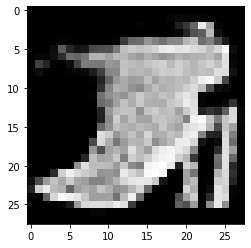

In [128]:
noise1 = np.random.randn(100, 100)
img = generator(noise1, training=True)
plt.imshow(img[0, :, :, 0], cmap='gray')

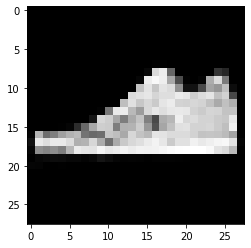

In [129]:
noise2 = np.random.randn(100, 100)
img = generator(noise2, training=True)
plt.imshow(img[5, :, :, 0], cmap='gray')

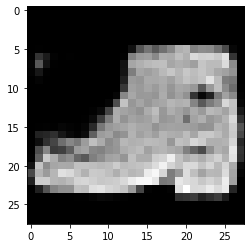

In [130]:
noise = (noise1 + noise2) / 2
img = generator(noise, training=True)
plt.imshow(img[0, :, :, 0], cmap='gray')